In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

import my_utils as myf
import matplotlib.path as mpath
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from matplotlib.gridspec import GridSpec

import xesmf as xe

In [2]:
mydir = '/glade/work/lettier/archived_data/202212_data_paper_nudge_winds_amoc/sst_1979-2016/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'HADISST' not in f and '2016' in f]

In [3]:
listds = []
for file in myfiles: 
    ds = xr.open_dataset(file)
    if 'z_t' in ds:
        ds = ds.drop('z_t')
    if 'TEMP_trend' in ds:
        ds = ds.rename({'TEMP_trend':'SST_trend','TEMP_p_value':'SST_p_value'})
    ds = ds.squeeze()
    ds = ds.set_coords('names')
    listds.append(ds)
ds = xr.concat(listds,dim='names')
ds['TLONG'] = ds.TLONG.isel(names=0)
ds['TLAT'] = ds.TLAT.isel(names=0)

In [4]:
ds['mask'] = xr.open_dataset('/glade/scratch/wriggles/archive/nudge_era_1950_ens01/ocn/hist/nudge_era_1950_ens01.pop.h.2000-01.nc').REGION_MASK

In [5]:
first = ds.isel(nlon=0)
first['nlon'] = 320
ds = xr.concat([ds,first],dim='nlon')

In [6]:
thelens = [f for f in ds.names.values if 'LENS' in f]
lensmean = ds.sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean = lensmean.set_coords('names')
ds = xr.concat([ds,lensmean],dim='names')

In [7]:
# this is on original grid
obds = xr.open_dataset(mydir+'HADISST.ocn_climtrend.1979-2016.nc')
obmask = xr.open_dataset('/glade/work/lettier/HADISST/HadISST_sst.nc').sel(time=slice('1979','2016')).sst.min(dim='time')

In [8]:
mynames = ['HADISST','CESM1FO','nudge_era_1950_ens01','LENSmean']
labels = ['HADISST','FO-CORE','NUDGE-ERA5','LENSmean']

In [9]:
ds['SST_trend'] = 10.*ds.SST_trend.where(ds.mask>0)
obds['SST_trend'] = 10*obds.SST_trend.where(obmask>-20)

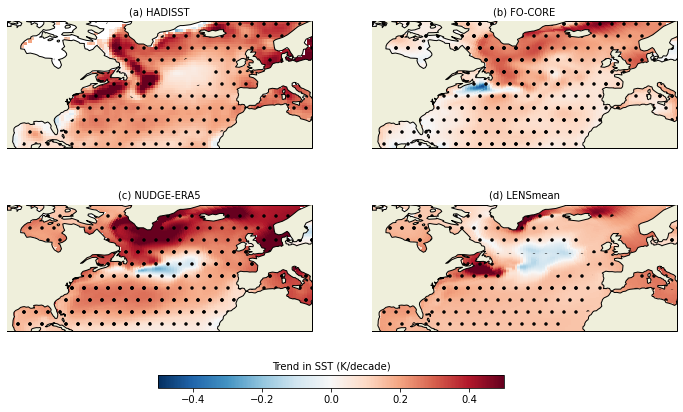

In [10]:
fig = plt.figure(figsize=(12,6))

for n, name in enumerate(mynames):
    ax = fig.add_subplot(2,2,n+1, projection = ccrs.PlateCarree(central_longitude=0))
    ax.set_extent([-100, 20, 20, 70], crs=ccrs.PlateCarree())
    label = ['a','b','c','d','e','f'][n]
    ax.set_title('('+str(label)+') '+labels[n],fontsize=10,loc='center')
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
  
    if name=='HADISST':
        
        CS1 = ax.pcolormesh(obds.longitude, obds.latitude, obds.SST_trend, 
                    vmax = .5, vmin=-.5, cmap = plt.cm.RdBu_r, transform=ccrs.PlateCarree())
        
        stip = plt.contourf(obds.longitude, obds.latitude, obds.SST_p_value, levels = [0.,5.], 
                            transform=ccrs.PlateCarree(), colors=['none'], hatches=['.'])
        
    else:
        
        CS1 = ax.pcolormesh(ds.TLONG, ds.TLAT, ds.SST_trend.sel(names=name), vmax = .5, vmin=-.5, cmap = plt.cm.RdBu_r,
                        transform=ccrs.PlateCarree())
        stip = plt.contourf(ds.TLONG, ds.TLAT, ds.SST_p_value.sel(names=name), levels = [0.,5.], 
                            transform=ccrs.PlateCarree(), colors=['none'], hatches=['.'])
       
    
plt.tight_layout()
plt.subplots_adjust(bottom = .1)
cbar_ax = fig.add_axes([0.3, 0.0, 0.4, 0.03]) #[left, bottom, width, height]
cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
cbar.ax.set_title('Trend in SST (K/decade)',fontsize=10)
fig.savefig('figs/suppFig9.pdf', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

In [11]:
obds = obds.rename({'latitude':'lat','longitude':'lon'})[['SST_trend']]
ds = ds.rename({'TLAT':'lat','TLONG':'lon'})
ds = ds.drop(['ULAT','ULONG'])
regridder = xe.Regridder(obds, ds, 'bilinear')
obdsr = regridder(obds)

Overwrite existing file: bilinear_180x360_384x321.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable SST_trend as the horizontal dimensions for this dataset.


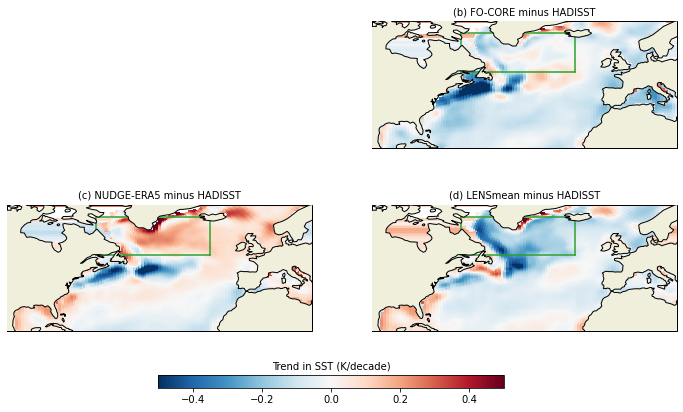

In [12]:
lon1, lon2 = 295, 340
lat1, lat2 = 50, 65

fig = plt.figure(figsize=(12,6))

for n, name in enumerate(mynames):
    if n>0:
        ax = fig.add_subplot(2,2,n+1, projection = ccrs.PlateCarree(central_longitude=0))
        ax.set_extent([-100, 20, 20, 70], crs=ccrs.PlateCarree())
        label = ['a','b','c','d','e','f'][n]
        ax.set_title('('+str(label)+') '+labels[n]+' minus HADISST',fontsize=10,loc='center')
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        
        CS1 = ax.pcolormesh(ds.lon, ds.lat, ds.SST_trend.sel(names=name)-obdsr.SST_trend, vmax = .5, vmin=-.5, cmap = plt.cm.RdBu_r,
                        transform=ccrs.PlateCarree())
         
    
        ax.plot([lon1, lon2], [lat1, lat1], transform=ccrs.PlateCarree(),c='tab:green')
        ax.plot([lon1, lon2], [lat2, lat2], transform=ccrs.PlateCarree(),c='tab:green')
        ax.plot([lon1, lon1], [lat1, lat2], transform=ccrs.PlateCarree(),c='tab:green')
        ax.plot([lon2, lon2], [lat1, lat2], transform=ccrs.PlateCarree(),c='tab:green')

plt.tight_layout()
plt.subplots_adjust(bottom = .1)
cbar_ax = fig.add_axes([0.3, 0.0, 0.4, 0.03]) #[left, bottom, width, height]
cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
cbar.ax.set_title('Trend in SST (K/decade)',fontsize=10)
plt.show()
plt.close()

In [13]:
ds = xr.concat([ds.SST_trend,obdsr.SST_trend],dim='names')

In [14]:
avg = ds.where(ds.lat>50.).where(ds.lat<=65).where(ds.lon<=340).where(ds.lon>295)
avg = avg.mean(dim=('nlat','nlon'))
avg

<xarray.DataArray 'SST_trend' (names: 39)>
array([ 0.22552224, -0.05026795,  0.06006709,  0.09717795,  0.20734387,
        0.14759441,  0.22162176,  0.1834397 ,  0.09135268,  0.17539369,
        0.13778299,  0.04823427, -0.03797427,  0.14604403,  0.07586275,
        0.10132725,  0.16611991,  0.0324273 ,  0.1163542 ,  0.15802911,
        0.14529163,  0.09610718,  0.05348157,  0.09805669,  0.02987155,
        0.03185007,  0.01505201,  0.01003929,  0.02361623,  0.03533549,
        0.06468711, -0.00581586,  0.20012334,  0.04392543,  0.17374676,
        0.15766768,  0.39059026,  0.09288477,  0.26072651])
Coordinates:
  * names    (names) object 'CESM1FO' 'LENS01' 'LENS02' ... 'LENSmean' 'HADISST'
Attributes:
    units:    degC/yr

In [15]:
ds.names.values

array(['CESM1FO', 'LENS01', 'LENS02', 'LENS03', 'LENS04', 'LENS05',
       'LENS06', 'LENS07', 'LENS08', 'LENS09', 'LENS10', 'LENS11',
       'LENS12', 'LENS13', 'LENS14', 'LENS15', 'LENS16', 'LENS17',
       'LENS18', 'LENS19', 'LENS20', 'LENS21', 'LENS22', 'LENS23',
       'LENS24', 'LENS25', 'LENS26', 'LENS27', 'LENS28', 'LENS29',
       'LENS30', 'LENS31', 'LENS32', 'LENS33', 'LENS34', 'LENS35',
       'nudge_era_1950_ens01', 'LENSmean', 'HADISST'], dtype=object)

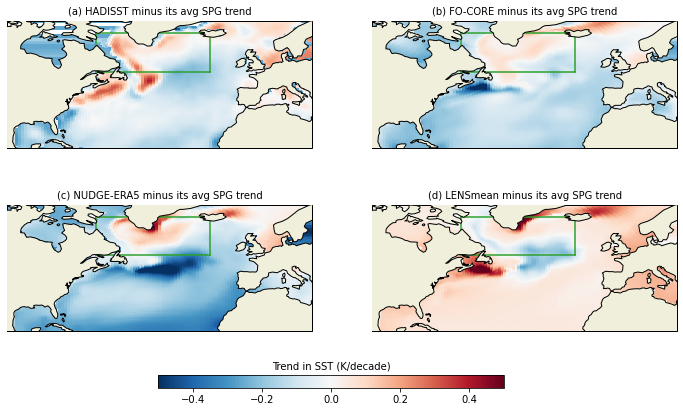

In [16]:
lon1, lon2 = 295, 340
lat1, lat2 = 50, 65

fig = plt.figure(figsize=(12,6))

for n, name in enumerate(mynames):

        ax = fig.add_subplot(2,2,n+1, projection = ccrs.PlateCarree(central_longitude=0))
        ax.set_extent([-100, 20, 20, 70], crs=ccrs.PlateCarree())
        label = ['a','b','c','d','e','f'][n]
        ax.set_title('('+str(label)+') '+labels[n]+' minus its avg SPG trend',fontsize=10,loc='center')
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        
        CS1 = ax.pcolormesh(ds.lon, ds.lat, ds.sel(names=name)-avg.sel(names=name), vmax = .5, vmin=-.5, cmap = plt.cm.RdBu_r,
                        transform=ccrs.PlateCarree())
         
    
        ax.plot([lon1, lon2], [lat1, lat1], transform=ccrs.PlateCarree(),c='tab:green')
        ax.plot([lon1, lon2], [lat2, lat2], transform=ccrs.PlateCarree(),c='tab:green')
        ax.plot([lon1, lon1], [lat1, lat2], transform=ccrs.PlateCarree(),c='tab:green')
        ax.plot([lon2, lon2], [lat1, lat2], transform=ccrs.PlateCarree(),c='tab:green')

plt.tight_layout()
plt.subplots_adjust(bottom = .1)
cbar_ax = fig.add_axes([0.3, 0.0, 0.4, 0.03]) #[left, bottom, width, height]
cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
cbar.ax.set_title('Trend in SST (K/decade)',fontsize=10)
fig.savefig('figs/xrr_sst.png', dpi=500, bbox_inches='tight')
plt.show()
plt.close()